In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import string
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import PorterStemmer
import nltk

from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
np.random.seed(42)

In [2]:
poem_raw = pd.read_csv("PoetryFoundationData.csv")
del poem_raw['Unnamed: 0']

In [3]:
#remove empty duplicate poems and reset index
poem_raw = poem_raw.drop_duplicates('Poem', False).reset_index(drop = True)

In [4]:
#remove tageless poems and reset index
poem_raw = poem_raw.drop_duplicates('Tags', False).reset_index(drop = True)

In [5]:
#make grouped tag strings a list of tags
tags_to_list = lambda tags: tags.replace('Seas, Rivers, & Streams', 'Seas & Rivers & Streams').split(',')
poem_raw.Tags = poem_raw.Tags.apply(tags_to_list)

In [6]:
# add word_count column
poem_raw['Word_count'] = poem_raw.Poem.map(lambda poem: len([term for term in poem.split(' ') if term != '']))

In [7]:
scl = MinMaxScaler()
poem_raw['Word_count_scaled'] = scl.fit_transform(poem_raw.Word_count.values.reshape(-1, 1))

In [8]:
# add scaled line_count column
line_count_func = lambda poem: len([line for line in poem.split('\r\r\n')])
poem_raw['Line_count'] = poem_raw.Poem.apply(line_count_func)
scl = MinMaxScaler()
poem_raw['Line_count_scaled'] = scl.fit_transform(poem_raw.Line_count.values.reshape(-1, 1))

In [9]:
# add scaled average word length column
def get_average_word_length(poem):
    poem = poem.replace('\r', ' ').replace('\n', ' ')
    poem = re.sub('[%s]' % re.escape(string.punctuation), ' ', poem.lower())
    word_lengths = [len(word) for word in poem.split(' ') if word != '']
    if not word_lengths: # fix this later, there is at least one empty poem in the dataset
        word_lengths.append(1)
    return sum(word_lengths)/len(word_lengths)
    
poem_raw['Ave_word_length'] = poem_raw.Poem.apply(get_average_word_length)
scl = MinMaxScaler()
poem_raw['Ave_word_length_scaled'] = scl.fit_transform(poem_raw.Ave_word_length.values.reshape(-1, 1))

In [10]:
#meaningful columns for content based recsys
poem_df = poem_raw[['Poet', 'Tags', 'Word_count_scaled', 'Line_count_scaled', 'Ave_word_length_scaled']]

In [11]:
# binarize tags and poets, NEED TO FIX TAGS
mlb = MultiLabelBinarizer()
tags_series = poem_df.Tags
tags_dummies = pd.DataFrame(mlb.fit_transform(tags_series),columns=mlb.classes_, index=poem_df.index)

poet_dummies = pd.get_dummies(poem_df.Poet, prefix = None)

poem_dummies = pd.concat([poem_df.Word_count_scaled, poet_dummies, tags_dummies], axis = 1)

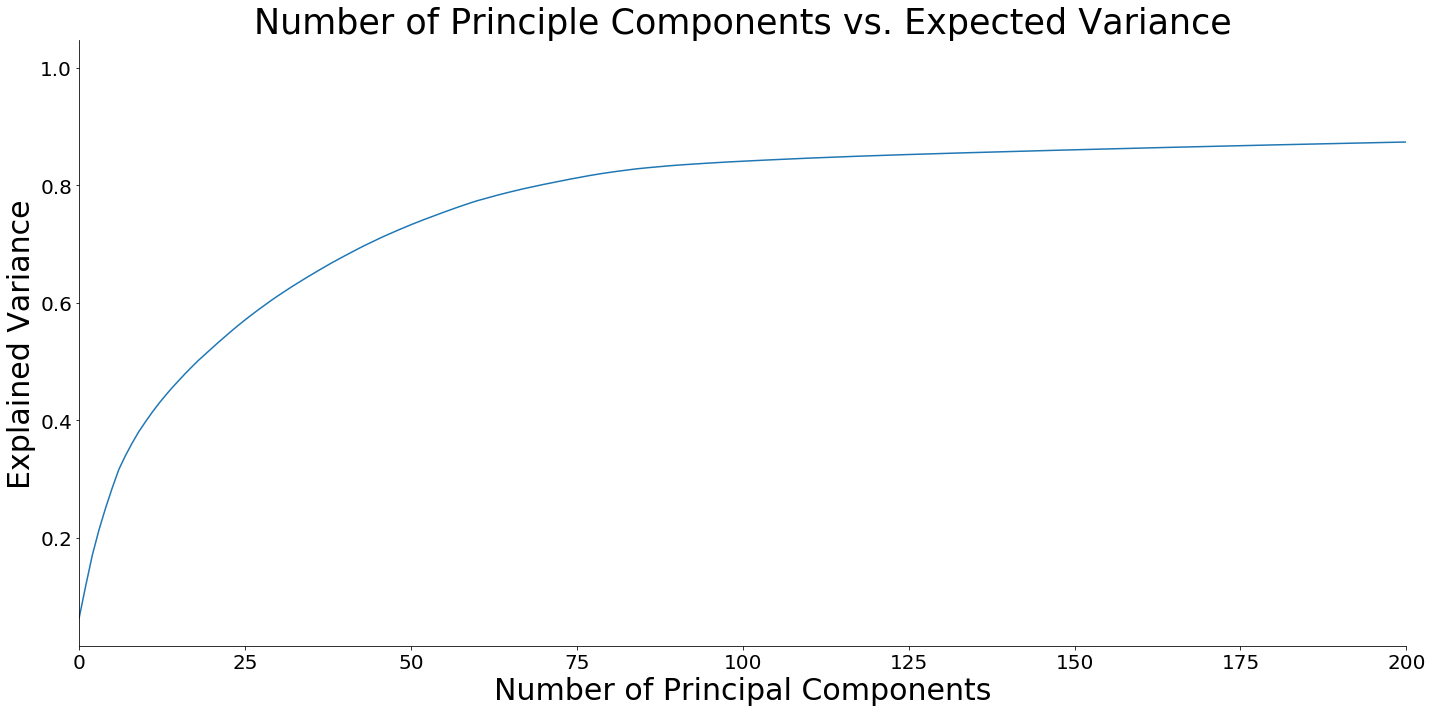

In [12]:
pca = PCA()

df_poem_pca = pca.fit_transform(poem_dummies)
exp_variances = pca.explained_variance_ratio_.cumsum()

# Plot explained variance
plt.figure(figsize = (20, 10))
plt.plot(exp_variances);
plt.xlabel("Number of Principal Components", fontsize = 30)
plt.ylabel("Explained Variance", fontsize = 30)
plt.xlim(0, 200)
plt.title("Number of Principle Components vs. Expected Variance", fontsize = 35)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tight_layout()
sns.despine()
plt.savefig('poem_pca200.png')

In [13]:
#get around 80% of varience from 75 principal components
df_poem_pca = df_poem_pca[:, :75]

In [14]:
dists = pairwise_distances(df_poem_pca, metric='cosine')

In [15]:
with open('flask_app/recommend_df.p', "wb") as path:
    pickle.dump(dists, path)
dists = pd.DataFrame(data=dists, index=poem_df.index, columns=poem_df.index)

In [16]:
#poems_i_like = [433, 0, 55, 1193, 1194, 1195, 6798]
poems_i_like = [4914,1246,683,4181,7022,4947]
poems_summed = dists[poems_i_like].sum(axis=1)
poems_summed = poems_summed.sort_values(ascending=True)

mask = ~poems_summed.index.isin(poems_i_like)
ranked_poems = poems_summed.index[mask]

ranked_poems = ranked_poems.tolist()

recs = ranked_poems[:10]
recs

[4330, 2223, 4674, 6437, 136, 1589, 2959, 4669, 6722, 4667]

In [17]:
recs[0]

4330

In [18]:
#poem_raw[poem_raw.Poet == 'Emily Dickinson'].Poem

In [19]:
poem_raw.iloc[poems_i_like]

,Title,Poem,Poet,Tags,Word_count,Word_count_scaled,Line_count,Line_count_scaled,Ave_word_length,Ave_word_length_scaled
4914,\r\r\n Redemption\r\r\n ...,"\r\r\nHaving been tenant long to a rich lord, ...",George Herbert,"[Activities, Jobs & Working, Religion, Faith &...",110,0.007585,3,0.000744,4.234234,0.359359
1246,\r\r\n St. Elizabeth\r\r\n ...,\r\r\nI run high in my body\r\r\non the road t...,Aracelis Girmay,"[Love, Infatuation & Crushes, Nature, Animals,...",193,0.013361,48,0.034226,3.892704,0.321412
683,\r\r\n Practicing﻿\r\r\n ...,\r\r\nI want to write a love poem for the girl...,Marie Howe,"[Living, Coming of Age, The Body, Love, Desire...",242,0.016771,30,0.020833,4.333333,0.370370
4181,\r\r\n How I Discovered Poe...,"\r\r\nIt was like soul-kissing, the way the wo...",Marilyn Nelson,"[Activities, School & Learning, Arts & Science...",122,0.008420,16,0.010417,3.963504,0.329278
7022,\r\r\n Triolet\r\r\n ...,\r\r\nShe was in love with the same danger\r\r...,Sandra McPherson,"[Living, Death, Marriage & Companionship, Love...",40,0.002714,10,0.005952,4.361702,0.373522
4947,\r\r\n Riding Herd\r\r\n ...,\r\r\nBarbed wires on rusted nails can’t hold\...,Walter McDonald,"[Love, Desire, Realistic & Complicated, Activi...",91,0.006263,18,0.011905,4.513761,0.390418


In [20]:
poem_raw.iloc[recs]

,Title,Poem,Poet,Tags,Word_count,Word_count_scaled,Line_count,Line_count_scaled,Ave_word_length,Ave_word_length_scaled
4330,\r\r\nfrom Odes: 30. The Orotava Road\r\r\n ...,\r\r\nFour white heifers with sprawling hooves...,Basil Bunting,"[Love, Desire, Realistic & Complicated, Activi...",245,0.016980,48,0.034226,4.409266,0.378807
2223,\r\r\n You Didn’t Hear It F...,\r\r\nthe bare-backed barback\r\r\nin the bear...,D. A. Powell,"[Love, Desire, Activities, Jobs & Working, Rel...",18,0.001183,6,0.002976,4.136364,0.348485
4674,\r\r\n Bar Napkin Sonnet #1...,\r\r\nThings happen when you drink too much me...,Moira Egan,"[Love, Desire, Realistic & Complicated, Activi...",110,0.007585,16,0.010417,3.674797,0.297200
6437,\r\r\n Infidelity\r\r\n ...,\r\r\nYou have not conquered me—it is the surg...,Louis Untermeyer,"[Love, Desire, Infatuation & Crushes, Realisti...",100,0.006889,18,0.011905,3.747826,0.305314
136,\r\r\n Minimum Wage\r\r\n ...,\r\r\nMy mother and I are on the front porch l...,Matthew Dickman,"[Love, Realistic & Complicated, Activities, Jo...",146,0.010090,20,0.013393,4.030675,0.336742
1589,\r\r\n Man Roulette\r\r\n ...,\r\r\nWhat booth is this? The last was a plast...,Brian Blanchfield,"[Love, Desire, Realistic & Complicated, Relati...",292,0.020251,36,0.025298,4.034375,0.337153
2959,\r\r\n Balcony Scene\r\r\n ...,\r\r\nUp — or out? — here:a problem of preposi...,Jameson Fitzpatrick,"[Love, Desire, Realistic & Complicated, Unrequ...",70,0.004802,3,0.000744,4.986842,0.442982
4669,\r\r\n [Didn’t Sappho say h...,\r\r\nDidn’t Sappho say her guts clutched up l...,Marilyn Hacker,"[Love, Desire, Infatuation & Crushes, Realisti...",99,0.006820,16,0.010417,4.566038,0.396226
6722,\r\r\n Iambicum Trimetrum\r...,"\r\r\nUnhappy verse, the witness of my unhappy...",Edmund Spenser,"[Love, Desire, Infatuation & Crushes, Realisti...",195,0.013500,17,0.011161,4.044554,0.338284
4667,\r\r\n A Maul for Bill and ...,"\r\r\nSwung from the toes out,\r\r\nBelly-brea...",Gary Snyder,"[Living, Marriage & Companionship, Love, Reali...",67,0.004593,18,0.011905,3.888889,0.320988


In [21]:
for idx, poem in enumerate(poem_raw.iloc[recs].Poem):
    print(idx)
    print('\n')
    print(poem)
    print('\n')

0



Four white heifers with sprawling hooves
         trundle the waggon.
   Its ill-roped crates heavy with fruit sway.
The chisel point of the goad, blue and white,
         glitters ahead,
   a flame to follow lance-high in a man’s hand
who does not shave. His linen trousers
         like him want washing.
   You can see his baked skin through his shirt.
He has no shoes and his hat has a hole in it.
         ‘Hu ! vaca ! Hu ! vaca !’
   he says staccato without raising his voice;
‘Adios caballero’ legato but
         in the same tone.
   Camelmen high on muzzled mounts
boots rattling against the panels
         of an empty
   packsaddle do not answer strangers.
Each with his train of seven or eight tied
         head to tail they
   pass silent but for the heavy bells
and plip of slobber dripping from
         muzzle to dust;
   save that on sand their soles squeak slightly.
Milkmaids, friendly girls between
         fourteen and twenty
   or younger, bolt upright on small
trotting

In [18]:
mydict = [{'a': 1, 'b': 2, 'c': 3, 'd': 4},
          {'a': 100, 'b': 200, 'c': 300, 'd': 400},
          {'a': 1000, 'b': 2000, 'c': 3000, 'd': 4000 }]
df = pd.DataFrame(mydict)
df

,a,b,c,d
0,1,2,3,4
1,100,200,300,400
2,1000,2000,3000,4000


In [19]:
from random import randint

In [20]:
poem_df

,Poet,Tags,Word_count_scaled
0,Joy Harjo,"[Living, Time & Brevity, Relationships, Family...",0.003897
1,Joy Harjo,"[Religion, The Spiritual, Mythology & Folklore...",0.007376
2,Simone White,"[Living, Parenthood, The Body, The Mind, Natur...",0.021434
3,Truong Tran,"[The Body, Family & Ancestors]",0.008490
4,Truong Tran,"[Infancy, Parenthood, The Body]",0.004454
...,...,...,...
7142,Kevin A. González,"[Living, Death, Sorrow & Grieving, Nature, Sea...",0.007864
7143,Robert Pinsky,"[Religion, Other Religions, The Spiritual, Art...",0.028601
7144,Albert Goldbarth,"[Activities, Eating & Drinking, Religion, Chri...",0.051357
7145,Gwendolyn Brooks,"[Living, Growing Old, Marriage & Companionship...",0.005010


In [21]:
def rand_poem():
    random_poem_idx = randint(0, poem_raw.Poem.shape[0] - 1)
    return poem_raw.loc[random_poem_idx]

In [96]:
poem = rand_poem()

In [97]:
len(poem.Poem.split('\r\r\n'))

22

In [98]:
print(poem.Poem)


Anyone who begins a sentence with, “In all honesty ... ”
is about to tell a lie. Anyone who says, “This is how I feel”
had better love form more than disclosure. Same for anyone
who thinks he thinks well because he had a thought.
If  you say, “You’re ugly” to an ugly person — no credit
for honesty, which must always be a discovery, an act
that qualifies as an achievement. If  you persist
you’re just a cruel bastard, a pig without a mirror,
somebody who hasn’t examined himself enough.
A hesitation hints at an attempt to be honest, suggests
a difficulty is present. A good sentence needs
a clause or two, interruptions, set off  by commas,
evidence of a slowing down, a rethinking.
Before I asked my wife to marry me, I told her
I’d never be fully honest. No one, she said,
had ever said that to her. I was trying
to be radically honest, I said, but in fact
had another motive. A claim without a “but” in it
is, at best, only half  true. In all honesty,
I was asking in advance to be forgiven.



In [125]:
'23,32'.split(',')

['23', '32']